In [1]:
import random

import equinox as eqx
import hydra
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from omegaconf import DictConfig, OmegaConf
import seaborn as sns

from phd.feature_search.scripts.jax_full_feature_search import train_step, train_multi_step, run_experiment, TrainState
from phd.feature_search.jax_core.experiment_helpers import prepare_components, rng_from_string, seed_from_string
from phd.feature_search.jax_core.models import MLP
from phd.feature_search.jax_core.tasks.geoff import NonlinearGEOFFTask

%matplotlib inline

if not hydra.core.global_hydra.GlobalHydra().is_initialized():
    hydra.initialize(config_path="../conf")

/home/edan/local_projects/phd_research/phd/feature_search/scripts/jax_full_feature_search.py:423: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path='../conf', config_name='full_feature_search')
/tmp/ipykernel_52221/3794935559.py:19: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="../conf")


In [2]:
def prepare_experiment(cfg):
    task, model, criterion, optimizer, repr_optimizer, cbp_tracker = \
        prepare_components(cfg)
    
    if cfg.seed is not None:
        rng = jax.random.key(cfg.seed)
    else:
        rng = jax.random.key(random.randint(0, 2**31))

    task_init_key = rng_from_string(rng, 'task_init_key')
    task.weights[-1] = jax.random.uniform(
        task_init_key,
        task.weights[-1].shape,
        minval = -jnp.sqrt(6 / task.weights[-1].shape[0]),
        maxval = jnp.sqrt(6 / task.weights[-1].shape[0]),
    )
    model = eqx.tree_at(
        lambda m: m.layers[-1].weight, model,
        jnp.zeros_like(model.layers[-1].weight),
    )
    return task, model, criterion, optimizer, repr_optimizer, cbp_tracker, rng


def prepare_and_run_experiment(cfg):
    task, model, criterion, optimizer, repr_optimizer, cbp_tracker, rng = \
        prepare_experiment(cfg)
    
    jax.config.update('jax_compilation_cache_dir', cfg.jax_jit_cache_dir)
    jax.config.update('jax_persistent_cache_min_entry_size_bytes', -1)
    jax.config.update('jax_persistent_cache_min_compile_time_secs', 0.1)
    jax.config.update('jax_persistent_cache_enable_xla_caches', 'xla_gpu_per_fusion_autotune_cache_dir')
    
    metrics = run_experiment(
        cfg, task, model, criterion, optimizer,
        repr_optimizer, cbp_tracker, None, rng,
    )
    
    return metrics

In [ ]:
experiment_base_cfg = DictConfig(dict(
    task = {
        'name': 'nonlinear_geoff',
        'n_features': 128,
        'n_real_features': '${task.n_features}',
        'flip_rate': 0.0,
        'n_layers': 4,
        'n_stationary_layers': 4,
        'hidden_dim': 128,
        'activation': 'ltu',
        'sparsity': 0.99,
        'weight_init': 'binary',
        'noise_std': 0.0,
    },
    train = {
        'batch_size': 1,
        'total_steps': 50_000,
        'standardize_cumulants': True,
        'log_freq': 500,
    },
    feature_recycling = {
        'use_cbp_utility': True,
        'use_signed_utility': False,
        'recycle_rate': 0.0,
        'utility_decay': 0.99,
        'feature_protection_steps': 100,
        'prune_frequency': 4,
    },
    model = {
        'output_dim': 1,
        'n_layers': 3,
        'hidden_dim': 128,
        'weight_init_method': 'lecun_uniform', # Input layer only
        'activation': 'ltu',
        'n_frozen_layers': 0,
        'use_bias': True,
    },
    optimizer = {
        'name': 'rmsprop',
        'learning_rate': 0.001,
    },
))

# Load hydra config
default_cfg = hydra.compose(config_name='nonlinear_geoff')
cfg = OmegaConf.merge(default_cfg, experiment_base_cfg)

/home/edan/miniconda3/envs/jax/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'nonlinear_geoff': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [4]:
train_state, task, metrics = prepare_and_run_experiment(cfg)

/home/edan/local_projects/phd_research/phd/feature_search/jax_core/experiment_helpers.py:359: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  cbp_tracker = CBPTracker(
Training: 100%|██████████| 50000/50000 [00:02<00:00, 23497.10it/s, loss=0.92254]


dict_keys(['baseline_loss', 'cumulative_loss', 'loss', 'samples', 'squared_targets', 'step'])


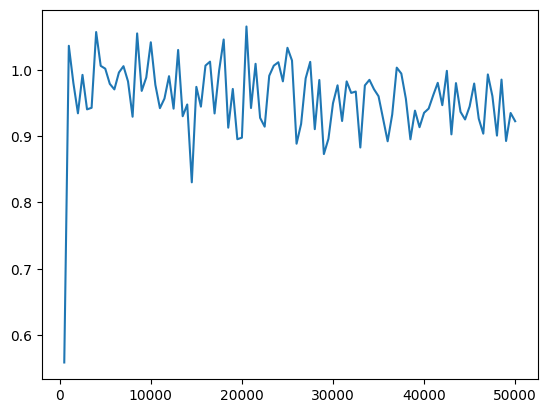

In [6]:
print(metrics.keys())
step = metrics['samples']
losses = metrics['loss']
plt.plot(step, losses)